<a href="https://colab.research.google.com/github/InscribeDeeper/bert_utils/blob/master/qa_bert_specialforgen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Baseline-3:-BioBERT-Pretrained---CNN-only" data-toc-modified-id="Baseline-3:-BioBERT-Pretrained---CNN-only-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Baseline 3: BioBERT Pretrained - CNN only</a></span></li><li><span><a href="#1.-Setup" data-toc-modified-id="1.-Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>1. Setup</a></span></li><li><span><a href="#2.-Parse-data" data-toc-modified-id="2.-Parse-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2. Parse data</a></span></li><li><span><a href="#3.-Tokenization-&amp;-Input-Formatting" data-toc-modified-id="3.-Tokenization-&amp;-Input-Formatting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>3. Tokenization &amp; Input Formatting</a></span></li><li><span><a href="#4.-Define-model" data-toc-modified-id="4.-Define-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>4. Define model</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#6.1.-Evalution-Function" data-toc-modified-id="6.1.-Evalution-Function-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>6.1. Evalution Function</a></span></li></ul></li><li><span><a href="#6.3.-4-fold-cross-validation;-one-vs-the-rest" data-toc-modified-id="6.3.-4-fold-cross-validation;-one-vs-the-rest-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>6.3. 4-fold cross validation; one-vs-the-rest</a></span></li></ul></li><li><span><a href="#7.-Train-a-model-with-all-data-for-prediction" data-toc-modified-id="7.-Train-a-model-with-all-data-for-prediction-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>7. Train a model with all data for prediction</a></span></li><li><span><a href="#Predict-sentences" data-toc-modified-id="Predict-sentences-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Predict sentences</a></span></li></ul></div>

# Baseline 3: BioBERT Pretrained - CNN only

---




In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#pip install --target=$package_path torchinfo

# 1. Setup

In [ ]:
import sys, os
# nb_path = '/content/rl'
# #os.symlink('/content/drive/MyDrive/Colab_Notebooks', nb_path)

# package_path = '/content/drive/MyDrive/Colab_Notebooks/packages'
# sys.path.insert(0,nb_path)
# sys.path.insert(0,package_path)

cur_path = os.path.join('/content/drive/MyDrive/Conf_Call/','Conf_Call')
print(os.getcwd())
os.chdir(cur_path)

/content


In [ ]:
import random, pickle
import numpy as np
from torch.nn import BCEWithLogitsLoss, BCELoss
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import torch
import pandas as pd

!pip install transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

!pip install torchinfo
from torchinfo import summary
from sklearn.model_selection import train_test_split, StratifiedKFold

import copy
from sklearn.utils import shuffle
import glob

import time
import datetime



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 81.4 MB/s 
     |████████████████████████████████| 120 kB 75.5 MB/s 


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Sep 16 04:29:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    device_name ="/cpu:0"
    print('GPU device not found')
    #raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available(): 

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# set seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Download BioBERT Base Model

# 2. Parse data

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [ ]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/drive/MyDrive/temp/merge_qa_label.csv", encoding="ISO-8859-1")
#df = pd.read_csv("surprise_checking_internal_0905.csv", encoding="ISO-8859-1")
#df = df[df.Negative==0]
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df = df.drop(['Unnamed: 0','Unnamed: 2'], axis=1)
# Display 10 random rows from the data.
df.sample(10)

# df = pd.read_excel("/content/drive/MyDrive/temp/surprise_dt_test_v9_all_kiera.xlsx")
# #df = df[df.Negative==0]
# # Report the number of sentences.
# print('Number of training sentences: {:,}\n'.format(df.shape[0]))
# df = df.drop(['Unnamed: 0'], axis=1)
# df = df.rename(columns={'merged':'label'})
# # Display 10 random rows from the data.
# df.sample(10)

Number of training sentences: 1,173



,sentence,label
316,That is also a same store number because we??v...,0
171,"How has that sort of changed the marketplace, ...",0
396,How has that been trending in the last quarter...,0
196,"I'm just wondering why is this, given the Olym...",1
357,And they are on track to continue that through...,0
1058,"You don??t think the industry, like everyone s...",0
284,"So, you are displacing - you are gaining marke...",1
1033,"How -- what was the timing, like was it at the...",0
48,"A few questions, first of all on the New Londo...",0
366,Why do you think it decelerated from Q3 high s...,0


In [ ]:
random.seed(3)

In [ ]:
len(df)
#df["label"] =df["label"].fillna(0)
df= df[~df['label'].isna()]

df.label.value_counts()

1173

0    928
1    245
Name: label, dtype: int64

In [ ]:
neg = 280
import sklearn
negs = sklearn.utils.shuffle(df[df.label==0].index.tolist())
df = df[(df.label==1) | (df.index.isin(negs[0:neg]))]

df.label.value_counts()

0    280
1    245
Name: label, dtype: int64

In [ ]:
df[df.label==0]

,sentence,label
0,But I??m just wondering how you actually manag...,0
8,What was that all in?,0
10,Is that any different than it was nine months ...,0
30,How did that come about?,0
40,So there wasn't an unusual boost in the North ...,0
...,...,...
1157,"And then one other, right; recently, you guys ...",0
1159,"And then, this contract Salisbury municipality...",0
1160,And so how do you see the uptick of that produ...,0
1163,I wondered if we could walk through some of th...,0




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/temp/traingsample.csv')

In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = [0,1]
num_labels = len(labels)
df.label.sum()

245

In [ ]:
labels[0:2]
print(len(labels))
print(len(sentences))

[0, 1]

2
525


In [ ]:
#df.to_csv('/content/drive/MyDrive/temp/traingsample.csv',index=False)

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain', do_lower_case=True )
# tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert', do_lower_case=True )


Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  But I??m just wondering how you actually manage that, when you??re looking at your underwriting teams and trying to manage their risks properly around a business that??s growing at such a high rate.
Tokenized:  ['but', 'i', '?', '?', 'm', 'just', 'wondering', 'how', 'you', 'actually', 'manage', 'that', ',', 'when', 'you', '?', '?', 're', 'looking', 'at', 'your', 'under', '##writing', 'teams', 'and', 'trying', 'to', 'manage', 'their', 'risks', 'properly', 'around', 'a', 'business', 'that', '?', '?', 's', 'growing', 'at', 'such', 'a', 'high', 'rate', '.']
Token IDs:  [2021, 1045, 1029, 1029, 1049, 2074, 6603, 2129, 2017, 2941, 6133, 2008, 1010, 2043, 2017, 1029, 1029, 2128, 2559, 2012, 2115, 2104, 18560, 2780, 1998, 2667, 2000, 6133, 2037, 10831, 7919, 2105, 1037, 2449, 2008, 1029, 1029, 1055, 3652, 2012, 2107, 1037, 2152, 3446, 1012]


In [ ]:

bert_model = AutoModel.from_pretrained(
    # 'ProsusAI/finbert',
    'bert-base-uncased',
    num_labels = 2, 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
    )
bert_model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Put everything together as a function. This is for pretrained word vectors

def get_pretrained_wordvector(sentences, tokenizer, bert_model):

    input_ids = []
    attention_masks = []
    max_len =100

    # For every sentence...
    for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        #padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
    
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])


    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    bert_model.eval()
    with torch.no_grad():

        outputs = bert_model(input_ids.to(device), attention_masks.to(device))   
        hidden_states = outputs[2]

    
    # get the last four layers
    token_embeddings = torch.stack(hidden_states[-4:], dim=0) 
    #print(token_embeddings.size())

    # permute axis
    token_embeddings = token_embeddings.permute(1,2,0,3)
    #print(token_embeddings.size())

    # take the mean of the last 4 layers
    token_embeddings = token_embeddings.mean(axis=2)

    #print(token_embeddings.size())

    return token_embeddings, attention_masks

In [ ]:
token_embeddings, masks = get_pretrained_wordvector(sentences, tokenizer, bert_model)
print(masks.size())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


torch.Size([525, 100])


In [ ]:
token_embeddings = token_embeddings.to(device) * masks.unsqueeze(-1).to(device)
print(token_embeddings.size())

torch.Size([525, 100, 768])


# 4. Define model


The model has two layers:
BiLSTM
CNN
Dense Layer

Depending on loss function used, this model can be single-label or multi-label

In [ ]:
class cnn(nn.Module):

    # define all the layers used in model
    def __init__(self, emb_dim, seq_len, num_filters, kernel_sizes, num_classes, dropout_rate = 0.5):
      
        super().__init__()
        self.emb_dim = emb_dim
        self.seq_len = seq_len
        
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.num_classes = num_classes

        #self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)
        
        self.convs = nn.ModuleList([nn.Conv2d(1,self.num_filters, (f, self.emb_dim)) for f in self.kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes)*self.num_filters, self.num_classes)

        self.dropout = nn.Dropout(p=dropout_rate)


    def forward(self, x):

        #x, _ = self.lstm(x)  # (N, seq_len, 2*lstm_units)

        x = x.unsqueeze(1)

        #print(x.size())

        x = [F.relu(conv(x).squeeze(-1)) for conv in self.convs]  # output of three conv

        #print(x[0].size())

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # continue with 3 maxpooling

        x = torch.cat(x, 1)  # N, len(filter_sizes)* num_filters
        #print(x.size())

        x = self.dropout(x)  # N, len(filter_sizes)* num_filters

        logit = self.fc(x)  # (N, num_classes)

        return logit

In [ ]:
class lstm_cnn(nn.Module):

    # define all the layers used in model
    def __init__(self, emb_dim, seq_len, lstm_units, num_filters, kernel_sizes, num_classes, dropout_rate = 0.5):
      
        super().__init__()
        self.emb_dim = emb_dim
        self.seq_len = seq_len
        self.lstm_units = lstm_units
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.num_classes = num_classes


        #self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)
        # input: [1173, 100, 768]
        # self.norm1 = torch.nn.LayerNorm([self.seq_len , self.emb_dim])
        # self.norm1 = nn.BatchNorm1d(seq_len)
        self.lstm = nn.LSTM(emb_dim,
                            lstm_units,
                            num_layers=1,
                            bidirectional=True,
                            batch_first=True)  # 
        
        self.convs = nn.ModuleList([nn.Conv2d(1,self.num_filters, (f, 2*self.lstm_units)) for f in self.kernel_sizes])
        # self.convs = nn.ModuleList([nn.Conv2d(1,self.num_filters, (f, self.lstm_units)) for f in self.kernel_sizes])
        #self.norm2 = nn.BatchNorm1d(len(kernel_sizes)*self.num_filters)
        self.fc = nn.Linear(len(kernel_sizes)*self.num_filters, self.num_classes)
        self.dropout = nn.Dropout(p=dropout_rate)
        


    def forward(self, x):

       # x = self.norm1(x)

        x, _ = self.lstm(x)  # (N, seq_len, 2*lstm_units)

        x = x.unsqueeze(1)

        #print(x.size())

        x = [F.relu(conv(x).squeeze(-1)) for conv in self.convs]  # output of three conv

        #print(x[0].size())

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # continue with 3 maxpooling

        x = torch.cat(x, 1)  # N, len(filter_sizes)* num_filters
        #print(x.size())

        #x = self.norm2(x)

        x = self.dropout(x)  # N, len(filter_sizes)* num_filters

        logit = self.fc(x)  # (N, num_classes)

        return logit

In [ ]:
model = cnn(100, 100, 32, [1,2,3], 6)
#summary(model.to(device),(32, 100, 100))
summary(model,(32, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
cnn                                      [32, 6]                   582
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [32, 32, 100, 1]          3,232
│    └─Conv2d: 2-2                       [32, 32, 99, 1]           6,432
│    └─Conv2d: 2-3                       [32, 32, 98, 1]           9,632
├─Linear: 1-4                            [32, 6]                   (recursive)
├─Dropout: 1-3                           [32, 96]                  --
├─Linear: 1-4                            [32, 6]                   (recursive)
Total params: 19,878
Trainable params: 19,878
Non-trainable params: 0
Total mult-adds (M): 60.96
Input size (MB): 1.28
Forward/backward pass size (MB): 2.43
Params size (MB): 0.08
Estimated Total Size (MB): 3.79

#6. **Define a function to train single-label classifier**

The loss function is different from multi-label classifer

Parameters:

* model: model defined
*   num_labels: number of labels
*   label_cols: label names
*   train_dataloader: train data loader
*   validation_dataloader: validation data loader
*   optimizer: optimizer. default is Adam
*   scheduler: adjust learning rate dynamically; default is None.
*   epochs: number of epochs


### 6.1. Evalution Function

In [ ]:
def model_eval(model, dataloader, class_weight = None):
  tokenized_texts = []
  true_labels = []
  pred_labels = []

  threshold = 0.5

  total_eval_accuracy = 0
  total_eval_loss = 0

  for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[1].to(device)

    with torch.no_grad():        

      logits = model(b_input_ids)
      #loss_func = BCELoss()
      #val_loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation

      if class_weight != None:
          pos_weight=torch.tensor(class_weight).to(device)
          loss_func = BCEWithLogitsLoss(pos_weight=pos_weight)
      else:
          loss_func = BCEWithLogitsLoss()

      val_loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation          
            
      total_eval_loss += val_loss.item()
    
      pred_label = torch.sigmoid(logits)   
      b_labels = b_labels.to('cpu').numpy()
      pred_label = pred_label.to('cpu').numpy()
      
      tokenized_texts.append(b_input_ids)
      true_labels.append(b_labels)
      pred_labels.append(pred_label)

    
  # Flatten outputs
  pred_labels = np.vstack(pred_labels)
  true_labels = np.vstack(true_labels)

  avg_val_loss = total_eval_loss / len(dataloader)    

  return tokenized_texts, pred_labels, true_labels,avg_val_loss
        


##6.2. Training Loop

In [ ]:
def train_single_label_model(model, num_labels, label_cols, train_dataloader, validation_dataloader, model_path,\
                             optimizer=None, scheduler=None, epochs = 10, \
                             class_weight = None, patience = 5):

    seed_val = 42

    threshold = 0.5
    #model_path = 'best_model.model'  # save the best model

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    training_stats = []
    
    best_score = -0.5
    best_epoch = 0
    cnt = 0

    total_t0 = time.time()

    if optimizer==None:
        optimizer = torch.optim.Adam(model.parameters())


    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        #print("")
        #print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        #print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            #if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
            #    elapsed = format_time(time.time() - t0)
                
                # Report progress.
                #print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_labels = batch[1].to(device)
            
            model.zero_grad()        

            logits = model(b_input_ids)
            #print("logits shape: ", b_input_ids.size(), b_labels.size(), logits.shape())
            #loss_func = BCELoss()
            #loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation

            # add class weight
            if class_weight != None:
              pos_weight=torch.tensor(class_weight).to(device)
              loss_func = BCEWithLogitsLoss(pos_weight=pos_weight)
            else:
              loss_func = BCEWithLogitsLoss()

            loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
            
            total_train_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # Update the learning rate.
            if scheduler!=None:
                scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        #training_time = format_time(time.time() - t0)

        #print("")
        #print("  Average training loss: {0:.2f}".format(avg_train_loss))
        #print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        #print("")
        #print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        tokenized_texts, pred_labels, true_labels,avg_val_loss = model_eval(model, validation_dataloader, class_weight = class_weight)

        pred_bools = np.argmax(pred_labels, axis = 1)
        true_bools = np.argmax(true_labels, axis = 1)
 
        val_f1 = f1_score(true_bools,pred_bools, average = None)*100 
        val_f1 = val_f1[1] # return f1 for  class 1
        val_acc = (pred_bools == true_bools).astype(int).sum()/len(pred_bools)

        #print('Validation Accuracy: {0:.4f}, F1: {1:.4f}, Loss: {2:.4f}'.format(val_f1, val_acc, avg_val_loss))
        #print(classification_report(np.array(true_labels), pred_bools, target_names=label_cols) )
        print("Epoch {0}\t Train Loss: {1:.4f}\t Val Loss {2:.4f}\t Val Acc: {3:.4f}\t Val F1: {4:.4f}".\
          format(epoch_i +1, avg_train_loss, avg_val_loss, val_acc, val_f1))

        # Measure how long the validation run took.
        #validation_time = format_time(time.time() - t0)
        
        #print("  Validation Loss: {0:.2f}".format(val_f1_accuracy))
        #print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': val_f1,
                'Best F1': best_score,
                'Best epoch': best_epoch
                #'Training Time': training_time,
                #'Validation Time': validation_time
            }
        )

        # early stopping
        if val_f1 > best_score:
            best_score = val_f1
            best_epoch = epoch_i + 1
            torch.save(copy.deepcopy(model.state_dict()), model_path)
            print("model saved")
            cnt = 0
        else:
            cnt += 1
            if cnt == patience:
                print("\n")
                print("early stopping at epoch {0}".format(epoch_i+1))

                break


    

    print("")
    #print("Training complete!")

    #print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return model, training_stats

## 6.3. 4-fold cross validation; one-vs-the-rest
Train single label classifier using one vs. the rest

In [ ]:
sentences = df.sentence.values
print(len(sentences))
#labels = list(df1.one_hot_labels.values)
#num_labels = len(label_cols)

vectors, masks = get_pretrained_wordvector(sentences, tokenizer, bert_model) 
vectors = vectors.to(device) * masks.unsqueeze(-1).to(device)

525


In [ ]:
batch_size = 32
emb_dim = vectors.size(-1)
seq_len = vectors.size(1)
num_filters = 64
kernel_sizes = [1, 3, 5]
num_labels = 2
labels = ['0','1']
class_weight = [1.0,2.0]

result = []
label_cols = ['label']

for col in label_cols:
    print("\n------------") 
    print(col)
    print("------------")
    
    y = df[col].astype(int).values

    fold = 0

    skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
    
    for train_index, test_index in skf.split(vectors, y): 

        print("\nfold {} \n".format(fold))

        fold += 1
        X_train, X_test = vectors[train_index], vectors[test_index]
        Y_train, Y_test = y[train_index], y[test_index]

        Y_train = pd.get_dummies(Y_train).values
        Y_train = torch.tensor(Y_train)

        Y_test = pd.get_dummies(Y_test).values
        Y_test = torch.tensor(Y_test)

        train_dataset = TensorDataset(X_train, Y_train)
        val_dataset = TensorDataset(X_test, Y_test)

        train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

        validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

        #weight = 10
        #train_sample_weight = np.array([weight if i ==1 else 1 for i in Y_train])
        #test_sample_weight = np.array([weight if i ==1 else 1 for i in Y_test])

        model_name =  "/content/drive/MyDrive/temp/bert_model/model_" + str(fold)
        #model = cnn(emb_dim, seq_len, num_filters, kernel_sizes, num_labels)
        model = lstm_cnn(emb_dim, seq_len, 100, \
                         num_filters, kernel_sizes, num_labels)
        model.to(device)


        model, training_stats = train_single_label_model(model, num_labels, labels, train_dataloader, validation_dataloader, \
                                                         model_path = model_name, class_weight = class_weight,
                                                        optimizer=None, scheduler=None, epochs = 20)
        
        print("load the best model ... ")

        model.load_state_dict(torch.load(model_name))

        # show performance of best model
        model.eval()
        tokenized_texts, pred_labels, true_labels,avg_val_loss = model_eval(model, validation_dataloader, class_weight = class_weight)

        pred_bools = np.argmax(pred_labels, axis = 1)
        true_bools = np.argmax(true_labels, axis = 1)

        p, r, f, _ = precision_recall_fscore_support(true_bools,pred_bools, pos_label = 1)
        #val_f1 = f1_score(true_bools,pred_bools, average = None)*100 
        #val_f1 = val_f1[1] # return f1 for  class 1
        val_acc = (pred_bools == true_bools).astype(int).sum()/len(pred_bools)
   
    
        print('Precision: {0:.4f}, Recall: {1:.4f}, F1: {2:.4f}, Loss: {3:.4f}'.format(p[1], r[1], f[1], avg_val_loss))
        print(classification_report(true_bools, pred_bools) )

        
    
        #p, r, f = train_model(model, X_train, Y_train, train_sample_weight,\
        #                   X_test, Y_test, test_sample_weight, \
        #                   'baseline_models/lstm_cnn/'+col)

        result.append([col, fold, p[1], r[1], f[1], training_stats[-1]["Best epoch"]])




------------
label
------------

fold 0 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.8290	 Val Loss 0.7777	 Val Acc: 0.6971	 Val F1: 70.3911
model saved
Epoch 2	 Train Loss: 0.6995	 Val Loss 0.6528	 Val Acc: 0.7314	 Val F1: 71.5152
model saved
Epoch 3	 Train Loss: 0.5336	 Val Loss 0.7061	 Val Acc: 0.7200	 Val F1: 71.3450
Epoch 4	 Train Loss: 0.3788	 Val Loss 0.7453	 Val Acc: 0.7200	 Val F1: 71.3450
Epoch 5	 Train Loss: 0.2493	 Val Loss 0.7977	 Val Acc: 0.7257	 Val F1: 71.7647
model saved
Epoch 6	 Train Loss: 0.1193	 Val Loss 1.3048	 Val Acc: 0.6914	 Val F1: 70.6522
Epoch 7	 Train Loss: 0.0750	 Val Loss 1.4521	 Val Acc: 0.7314	 Val F1: 74.0331
model saved
Epoch 8	 Train Loss: 0.0150	 Val Loss 1.4820	 Val Acc: 0.7429	 Val F1: 72.0497
Epoch 9	 Train Loss: 0.0068	 Val Loss 1.5977	 Val Acc: 0.7486	 Val F1: 72.5000
Epoch 10	 Train Loss: 0.0029	 Val Loss 1.8047	 Val Acc: 0.7486	 Val F1: 71.7949
Epoch 11	 Train Loss: 0.0024	 Val Loss 1.8821	 Val Acc: 0.7200	 Val F1: 71.3450
Epoch 12	 Train Loss: 0.0010	 Val Loss 2.1333	 Val Acc: 0.7486	 Val F1: 72.1519



<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.6700, Recall: 0.8272, F1: 0.7403, Loss: 1.4521
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        94
           1       0.67      0.83      0.74        81

    accuracy                           0.73       175
   macro avg       0.74      0.74      0.73       175
weighted avg       0.75      0.73      0.73       175


fold 1 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.8060	 Val Loss 0.7495	 Val Acc: 0.7257	 Val F1: 73.3333
model saved
Epoch 2	 Train Loss: 0.6508	 Val Loss 0.6531	 Val Acc: 0.7086	 Val F1: 74.8768
model saved
Epoch 3	 Train Loss: 0.5120	 Val Loss 0.7055	 Val Acc: 0.7200	 Val F1: 75.3769
model saved
Epoch 4	 Train Loss: 0.4442	 Val Loss 0.6932	 Val Acc: 0.7486	 Val F1: 70.2703
Epoch 5	 Train Loss: 0.2864	 Val Loss 0.9322	 Val Acc: 0.7371	 Val F1: 67.6056
Epoch 6	 Train Loss: 0.2055	 Val Loss 0.8885	 Val Acc: 0.7429	 Val F1: 73.0539
Epoch 7	 Train Loss: 0.0849	 Val Loss 1.1818	 Val Acc: 0.7143	 Val F1: 69.8795
Epoch 8	 Train Loss: 0.0218	 Val Loss 1.4575	 Val Acc: 0.7200	 Val F1: 72.0000


early stopping at epoch 8

load the best model ... 


<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.6410, Recall: 0.9146, F1: 0.7538, Loss: 0.7055
              precision    recall  f1-score   support

           0       0.88      0.55      0.68        93
           1       0.64      0.91      0.75        82

    accuracy                           0.72       175
   macro avg       0.76      0.73      0.71       175
weighted avg       0.77      0.72      0.71       175


fold 2 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.8027	 Val Loss 0.7447	 Val Acc: 0.5371	 Val F1: 65.8228
model saved
Epoch 2	 Train Loss: 0.6225	 Val Loss 0.5784	 Val Acc: 0.7657	 Val F1: 74.8466
model saved
Epoch 3	 Train Loss: 0.4641	 Val Loss 0.5695	 Val Acc: 0.7714	 Val F1: 75.9036
model saved
Epoch 4	 Train Loss: 0.3056	 Val Loss 0.6434	 Val Acc: 0.7657	 Val F1: 76.0234
model saved
Epoch 5	 Train Loss: 0.1460	 Val Loss 0.8293	 Val Acc: 0.7714	 Val F1: 72.9730
Epoch 6	 Train Loss: 0.0587	 Val Loss 0.9876	 Val Acc: 0.7429	 Val F1: 71.6981
Epoch 7	 Train Loss: 0.0161	 Val Loss 1.3674	 Val Acc: 0.7314	 Val F1: 67.1329
Epoch 8	 Train Loss: 0.0202	 Val Loss 1.3070	 Val Acc: 0.7486	 Val F1: 72.1519
Epoch 9	 Train Loss: 0.0216	 Val Loss 1.3371	 Val Acc: 0.7543	 Val F1: 72.6115


early stopping at epoch 9

load the best model ... 


<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.7303, Recall: 0.7927, F1: 0.7602, Loss: 0.6434
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        93
           1       0.73      0.79      0.76        82

    accuracy                           0.77       175
   macro avg       0.77      0.77      0.77       175
weighted avg       0.77      0.77      0.77       175



In [ ]:
result_df = pd.DataFrame(result, columns =["label","fold","precision","recall","f1","epoch"])

for col in label_cols:
    print(col)
    print(result_df[result_df.label == col][["precision","recall","f1","epoch"]])
    print(" ")
print(result_df[["label","precision","recall","f1","epoch"]].groupby("label").mean())

label
   precision    recall        f1  epoch
0   0.670000  0.827160  0.740331      7
1   0.641026  0.914634  0.753769      3
2   0.730337  0.792683  0.760234      4
 
       precision    recall        f1     epoch
label                                         
label   0.680454  0.844826  0.751445  4.666667


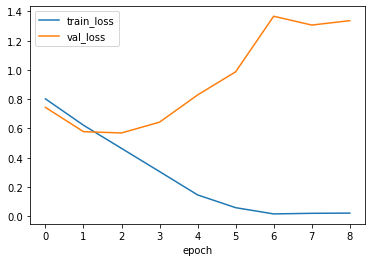

In [ ]:
from matplotlib import pyplot as plt
loss = [[i, item['Training Loss'], item['Valid. Loss']] for i, item in enumerate(training_stats)]
acc = [[item["Best epoch"], 'Valid. Accur.'] for item in training_stats]

pd.DataFrame(loss, columns=["epoch", "train_loss","val_loss"]).set_index("epoch").plot(kind="line")
plt.show()

In [ ]:
sentences = df.sentence.values
print(len(sentences))
#labels = list(df1.one_hot_labels.values)
#num_labels = len(label_cols)

vectors, masks = get_pretrained_wordvector(sentences, tokenizer, bert_model) 
vectors =  vectors.to(device) * masks.unsqueeze(-1).to(device)

525


In [ ]:
# use our labeled data

batch_size = 32
emb_dim = vectors.size(-1)
seq_len = vectors.size(1)
num_filters = 64
kernel_sizes = [1, 3, 5]
num_labels = 2
labels = ['0','1']
class_weight = [1.0,1.0]

result = []
label_cols = ['label']

for col in label_cols:
    print("\n------------") 
    print(col)
    print("------------")
    
    y = df[col].astype(int).values

    fold = 0

    skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    
    for train_index, test_index in skf.split(vectors, y): 

        print("\nfold {} \n".format(fold))

        fold += 1
        X_train, X_test = vectors[train_index], vectors[test_index]
        Y_train, Y_test = y[train_index], y[test_index]

        Y_train = pd.get_dummies(Y_train).values
        Y_train = torch.tensor(Y_train)

        Y_test = pd.get_dummies(Y_test).values
        Y_test = torch.tensor(Y_test)

        train_dataset = TensorDataset(X_train, Y_train)
        val_dataset = TensorDataset(X_test, Y_test)

        train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

        validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

        #weight = 10
        #train_sample_weight = np.array([weight if i ==1 else 1 for i in Y_train])
        #test_sample_weight = np.array([weight if i ==1 else 1 for i in Y_test])

        model_name = "/content/drive/MyDrive/temp/bert_model/model_" + str(fold)
        #model = cnn(emb_dim, seq_len, num_filters, kernel_sizes, num_labels)
        model = lstm_cnn(emb_dim, seq_len, 100, \
                         num_filters, kernel_sizes, num_labels)
        model.to(device)


        model, training_stats = train_single_label_model(model, num_labels, labels, train_dataloader, validation_dataloader, \
                                                         model_path = model_name, class_weight = class_weight,
                                                        optimizer=None, scheduler=None, epochs = 20)
        
        print("load the best model ... ")

        model.load_state_dict(torch.load(model_name))

        # show performance of best model
        model.eval()
        tokenized_texts, pred_labels, true_labels,avg_val_loss = model_eval(model, validation_dataloader, class_weight = class_weight)

        pred_bools = np.argmax(pred_labels, axis = 1)
        true_bools = np.argmax(true_labels, axis = 1)

        p, r, f, _ = precision_recall_fscore_support(true_bools,pred_bools, pos_label = 1)
        #val_f1 = f1_score(true_bools,pred_bools, average = None)*100 
        #val_f1 = val_f1[1] # return f1 for  class 1
        val_acc = (pred_bools == true_bools).astype(int).sum()/len(pred_bools)
   
    
        print('Precision: {0:.4f}, Recall: {1:.4f}, F1: {2:.4f}, Loss: {3:.4f}'.format(p[1], r[1], f[1], avg_val_loss))
        print(classification_report(true_bools, pred_bools) )

        
    
        #p, r, f = train_model(model, X_train, Y_train, train_sample_weight,\
        #                   X_test, Y_test, test_sample_weight, \
        #                   'baseline_models/lstm_cnn/'+col)

        result.append([col, fold, p[1], r[1], f[1], training_stats[-1]["Best epoch"]])


------------
label
------------

fold 0 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.6799	 Val Loss 0.6479	 Val Acc: 0.6914	 Val F1: 67.8571
model saved
Epoch 2	 Train Loss: 0.5372	 Val Loss 0.5536	 Val Acc: 0.7314	 Val F1: 65.1852
Epoch 3	 Train Loss: 0.4209	 Val Loss 0.6596	 Val Acc: 0.7029	 Val F1: 62.3188
Epoch 4	 Train Loss: 0.3131	 Val Loss 0.6396	 Val Acc: 0.7314	 Val F1: 68.0272
model saved
Epoch 5	 Train Loss: 0.1829	 Val Loss 0.7523	 Val Acc: 0.7314	 Val F1: 69.2810
model saved
Epoch 6	 Train Loss: 0.0807	 Val Loss 0.9601	 Val Acc: 0.7200	 Val F1: 67.5497
Epoch 7	 Train Loss: 0.0224	 Val Loss 1.2085	 Val Acc: 0.7314	 Val F1: 70.4403
model saved
Epoch 8	 Train Loss: 0.0100	 Val Loss 1.6133	 Val Acc: 0.6686	 Val F1: 67.7778
Epoch 9	 Train Loss: 0.0057	 Val Loss 1.6232	 Val Acc: 0.6800	 Val F1: 67.4419
Epoch 10	 Train Loss: 0.0019	 Val Loss 1.6069	 Val Acc: 0.7486	 Val F1: 70.6667
model saved
Epoch 11	 Train Loss: 0.0014	 Val Loss 1.7661	 Val Acc: 0.7200	 Val F1: 70.6587
Epoch 12	 Train Loss: 0.0007	 Val Loss 1.8678	 Val Acc: 0.7029	 Val F

<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.7368, Recall: 0.6914, F1: 0.7134, Loss: 1.8235
              precision    recall  f1-score   support

           0       0.75      0.79      0.77        94
           1       0.74      0.69      0.71        81

    accuracy                           0.74       175
   macro avg       0.74      0.74      0.74       175
weighted avg       0.74      0.74      0.74       175


fold 1 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.6838	 Val Loss 0.6566	 Val Acc: 0.5543	 Val F1: 9.3023
model saved
Epoch 2	 Train Loss: 0.5851	 Val Loss 0.5687	 Val Acc: 0.6857	 Val F1: 69.2737
model saved
Epoch 3	 Train Loss: 0.4494	 Val Loss 0.5758	 Val Acc: 0.6914	 Val F1: 72.7273
model saved
Epoch 4	 Train Loss: 0.3695	 Val Loss 0.5476	 Val Acc: 0.7257	 Val F1: 65.2174
Epoch 5	 Train Loss: 0.2264	 Val Loss 0.5874	 Val Acc: 0.7543	 Val F1: 69.9301
Epoch 6	 Train Loss: 0.1255	 Val Loss 0.7687	 Val Acc: 0.7429	 Val F1: 68.0851
Epoch 7	 Train Loss: 0.0377	 Val Loss 1.0241	 Val Acc: 0.7371	 Val F1: 71.9512
Epoch 8	 Train Loss: 0.0113	 Val Loss 1.2451	 Val Acc: 0.7257	 Val F1: 69.2308


early stopping at epoch 8

load the best model ... 


<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.6207, Recall: 0.8780, F1: 0.7273, Loss: 0.5758
              precision    recall  f1-score   support

           0       0.83      0.53      0.64        93
           1       0.62      0.88      0.73        82

    accuracy                           0.69       175
   macro avg       0.73      0.70      0.69       175
weighted avg       0.73      0.69      0.68       175


fold 2 



lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.6910	 Val Loss 0.6593	 Val Acc: 0.7029	 Val F1: 69.4118
model saved
Epoch 2	 Train Loss: 0.5837	 Val Loss 0.5460	 Val Acc: 0.7200	 Val F1: 63.1579
Epoch 3	 Train Loss: 0.4681	 Val Loss 0.5202	 Val Acc: 0.7314	 Val F1: 65.6934
Epoch 4	 Train Loss: 0.3796	 Val Loss 0.5623	 Val Acc: 0.7143	 Val F1: 62.6866
Epoch 5	 Train Loss: 0.2348	 Val Loss 0.5901	 Val Acc: 0.7829	 Val F1: 75.9494
model saved
Epoch 6	 Train Loss: 0.1521	 Val Loss 0.6756	 Val Acc: 0.7429	 Val F1: 69.3878
Epoch 7	 Train Loss: 0.0651	 Val Loss 0.8417	 Val Acc: 0.7543	 Val F1: 73.9394
Epoch 8	 Train Loss: 0.0169	 Val Loss 1.1765	 Val Acc: 0.7200	 Val F1: 69.1824
Epoch 9	 Train Loss: 0.0038	 Val Loss 1.6708	 Val Acc: 0.7200	 Val F1: 72.9282
Epoch 10	 Train Loss: 0.0020	 Val Loss 1.5605	 Val Acc: 0.7029	 Val F1: 65.7895


early stopping at epoch 10

load the best model ... 


<All keys matched successfully>

lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Precision: 0.7895, Recall: 0.7317, F1: 0.7595, Loss: 0.5901
              precision    recall  f1-score   support

           0       0.78      0.83      0.80        93
           1       0.79      0.73      0.76        82

    accuracy                           0.78       175
   macro avg       0.78      0.78      0.78       175
weighted avg       0.78      0.78      0.78       175



In [ ]:
result_df = pd.DataFrame(result, columns =["label","fold","precision","recall","f1","epoch"])

for col in label_cols:
    print(col)
    print(result_df[result_df.label == col][["precision","recall","f1","epoch"]])
    print(" ")
print(result_df[["label","precision","recall","f1","epoch"]].groupby("label").mean())

label
   precision    recall        f1  epoch
0   0.736842  0.691358  0.713376     13
1   0.620690  0.878049  0.727273      3
2   0.789474  0.731707  0.759494      5
 
       precision    recall        f1  epoch
label                                      
label   0.715668  0.767038  0.733381    7.0


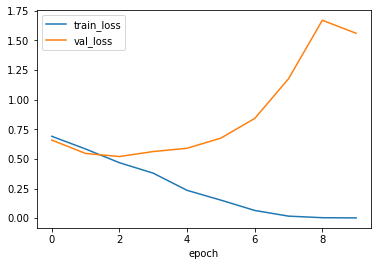

In [ ]:
from matplotlib import pyplot as plt
loss = [[i, item['Training Loss'], item['Valid. Loss']] for i, item in enumerate(training_stats)]
acc = [[item["Best epoch"], 'Valid. Accur.'] for item in training_stats]

pd.DataFrame(loss, columns=["epoch", "train_loss","val_loss"]).set_index("epoch").plot(kind="line")
plt.show()

# 7. Train a model with all data for prediction


In [ ]:
batch_size = 32
emb_dim = vectors.size(-1)
seq_len = vectors.size(1)
num_filters = 64
kernel_sizes = [1, 3, 5]
num_labels = 2
labels = ['0','1']
class_weight = [1.0,1.0]

epochs = 7

result = []
X_train =  torch.tensor(vectors)
Y_train = torch.tensor(pd.get_dummies(df.label).values)

X_val =  torch.tensor(vectors[0:100])
Y_val = torch.tensor(pd.get_dummies(df.label).values[0:100])

# not needed. just to fulfill the traning function need
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)  

train_dataloader = DataLoader(
    train_dataset,  # The training samples.
    sampler = RandomSampler(train_dataset), # Select batches randomly
    batch_size = batch_size # Trains with this batch size.
)

validation_dataloader = DataLoader(
    val_dataset, # The validation samples.
    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
    batch_size = batch_size # Evaluate with this batch size.
)

model_name = '/content/drive/MyDrive/temp/bert_model/genbert_forpred_v2'
model = lstm_cnn(emb_dim, seq_len, 100, num_filters, kernel_sizes, num_labels)

model.to(device)

model, training_stats = train_single_label_model(model, num_labels, labels, train_dataloader, validation_dataloader, \
                                                         model_path = model_name, class_weight = class_weight,
                                                        optimizer=None, scheduler=None, \
                                                        epochs = epochs, patience = 8)
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


lstm_cnn(
  (lstm): LSTM(768, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch 1	 Train Loss: 0.6600	 Val Loss 0.5186	 Val Acc: 0.8400	 Val F1: 90.1235
model saved
Epoch 2	 Train Loss: 0.5130	 Val Loss 0.3386	 Val Acc: 0.8800	 Val F1: 92.7711
model saved
Epoch 3	 Train Loss: 0.3815	 Val Loss 0.1561	 Val Acc: 0.9400	 Val F1: 96.5116
model saved
Epoch 4	 Train Loss: 0.2424	 Val Loss 0.0984	 Val Acc: 0.9700	 Val F1: 98.2249
model saved
Epoch 5	 Train Loss: 0.1440	 Val Loss 0.0536	 Val Acc: 0.9800	 Val F1: 98.8235
model saved
Epoch 6	 Train Loss: 0.0706	 Val Loss 0.2302	 Val Acc: 0.9100	 Val F1: 94.4099
Epoch 7	 Train Loss: 0.0650	 Val Loss 0.0156	 Val Acc: 0.9900	 Val F1: 99.4152
model saved



# Predict sentences

In [ ]:
bert_pred = pd.read_csv('/content/drive/MyDrive/temp/raw_text_forbert.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
bert_pred.head()

,text,encoded_unique_ticker_ts,rid
0,"Chun Hong, you're accusing DRAM of being high ...",new386,1
1,So you are talking about trending issue rather...,new386,2
2,What do you predict the -- I assume it will be...,new386,3
3,[indiscernible].,new386,4
4,That covers the cooling?,new386,5


In [ ]:
bert_pred.isnull().sum()

text                        30
encoded_unique_ticker_ts     0
rid                          0
dtype: int64

In [ ]:
bert_pred = bert_pred.dropna()

In [ ]:
bert_pred.shape

(4334161, 3)

In [ ]:
model_path= '/content/drive/MyDrive/temp/bert_model/genbert_forpred_v2'
emb_dim = 768
seq_len = 100
num_filters = 64
kernel_sizes = [1,3,5]
num_labels = 2
labels = ['0','1']
class_weight = [1.0,2] 
    
the_model = lstm_cnn(emb_dim, seq_len, 100, num_filters, kernel_sizes, num_labels)
the_model.load_state_dict(torch.load(model_path))
the_model = the_model.to(device)
the_model.eval()

NameError: ignored

In [ ]:
conf_ids = bert_pred["encoded_unique_ticker_ts"].unique().tolist()
len(conf_ids)

In [ ]:
target_file = '/content/drive/MyDrive/temp/predict_skp_gen_v2.csv'
checkpoint = 0

if os.path.isfile(target_file):
  result = pd.read_csv(target_file)

  if len(bert_pred) >0:
    checkpoint = conf_ids.index(result["rid"].iloc[-1])
    checkpoint += 1
  else:
    result = pd.DataFrame([], columns = ["encoded_unique_ticker_ts","rid", "text", "predict"])
    result.to_csv(target_file, header=True, index = False)
else:
  result = pd.DataFrame([], columns = ["encoded_unique_ticker_ts","rid", "text", "predict"])
  result.to_csv(target_file, header=True, index = False)

print(checkpoint)

59086


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
result.shape

(4334161, 4)

In [ ]:
start = time.time()
batch_size  = 200

for cid in conf_ids[checkpoint:]:
  result = bert_pred[bert_pred.encoded_unique_ticker_ts==cid].copy()
  preds = []
  for i in range(0, len(result), batch_size):
    # get embedding
    x, masks = get_pretrained_wordvector(result["text"].iloc[i:(i+batch_size)], tokenizer, bert_model)
    x =  x * (masks.unsqueeze(-1).to(device))  ## 这里利用的是 broadcasting
    x = x.to(device)

    with torch.no_grad():
      pred = the_model(x)
      pred = torch.softmax(pred, dim = -1)
      pred = pred[:,-1].detach().cpu().numpy()

      preds.append(pred)
     
  result["predict"] = np.concatenate(preds, axis = 0)
  result.to_csv(target_file, header=False, index= False, mode='a')

  checkpoint += 1

  if checkpoint%100 ==0:
    print("{0}: {1: .2f}".format(checkpoint, time.time()-start))

100:  68.46
200:  145.18
300:  215.88
400:  292.69
500:  372.65
600:  450.12
700:  515.31
800:  585.78
900:  664.95
1000:  746.13
1100:  822.90
1200:  899.05
1300:  983.69
1400:  1058.92
1500:  1130.58
1600:  1195.09
1700:  1271.10
1800:  1344.76
1900:  1416.31
2000:  1495.99
2100:  1578.61
2200:  1644.30
2300:  1710.51
2400:  1789.53
2500:  1874.00
2600:  1950.14
2700:  2019.27
2800:  2081.03
2900:  2157.85
3000:  2227.28
3100:  2310.10
3200:  2383.64
3300:  2462.97
3400:  2550.28
3500:  2630.66
3600:  2718.38
3700:  2802.27
3800:  2888.60
3900:  2976.14
4000:  3033.84
4100:  3108.99
4200:  3192.83
4300:  3260.18
4400:  3352.94
4500:  3423.97
4600:  3521.37
4700:  3640.23
4800:  3727.47
4900:  3806.14
5000:  3904.75
5100:  3984.05
5200:  4046.22
5300:  4126.88
5400:  4225.50
5500:  4286.50
5600:  4364.13
5700:  4461.23
5800:  4540.54
5900:  4629.08
6000:  4686.93
6100:  4751.60
6200:  4850.60
6300:  4924.81
6400:  5001.53
6500:  5087.23
6600:  5195.86
6700:  5266.32
6800:  5338.98
690